In [1]:
using Random
using Distributions
using LinearAlgebra
using ForwardDiff
include("../Inversion/Plot.jl")
include("../Inversion/GMWVI.jl")

Gaussian_mixture_WGFVI (generic function with 1 method)

## Gaussian mixture

This is not an inverse problem!

$$
e^{-\Phi_r(\theta)} \propto \sum_i w_i \mathcal{N}(\theta; m_i, C_i) \\
\Phi_r(\theta) = - \log\Bigl( \sum_i w_i \mathcal{N}(\theta; m_i, C_i) \Bigr)
$$



In [2]:
function log_Gaussian_mixture(x, args)
    x_w, x_mean, inv_sqrt_x_cov = args
    # C = L L.T
    # C^-1 = L^-TL^-1
    N_x = size(x_mean, 2)
    ρ = 0
    for im = 1:length(x_w)
        ρ += x_w[im]*exp(-0.5*(x-x_mean[im,:])'*(inv_sqrt_x_cov[im]'*inv_sqrt_x_cov[im]*(x-x_mean[im,:])))/det(inv_sqrt_x_cov[im])
    end
    return log(ρ) - N_x/2*log(2*π)
end



function Gaussian_mixture_dPhi(θ, args)
    return -log_Gaussian_mixture(θ, args), 
           -ForwardDiff.gradient(x -> log_Gaussian_mixture(x, args), θ), 
           -ForwardDiff.hessian(x -> log_Gaussian_mixture(x, args), θ)
end



Gaussian_mixture_dPhi (generic function with 1 method)

In [3]:
#=
fig, ax = PyPlot.subplots(nrows=4, ncols=3, sharex=false, sharey=false, figsize=(20,20))

x_w_ref, x_mean_ref = [0.2;0.5;0.3], [1.0 2.0; 2.0 1.0; -1.0 -1.0]
N_modes_ref, N_x = size(x_mean_ref)
xx_cov_ref = zeros(N_modes_ref, 2, 2)
for im = 1:N_modes_ref
    xx_cov_ref[im,:,:] += I
end
xx_cov_ref[N_modes_ref,:,:] /= 2.0

inv_sqrt_x_cov_ref = [compute_sqrt_matrix(xx_cov_ref[im,:,:]; type="Cholesky")[2] for im = 1:N_modes_ref]
func_args = (x_w_ref, x_mean_ref, inv_sqrt_x_cov_ref)
func_dPhi(x) = Gaussian_mixture_dPhi(x, func_args)
func_Phi(x) = -log_Gaussian_mixture(x, func_args)



Random.seed!(111);
N_modes = 5
x0_w  = ones(N_modes)/N_modes
μ0, Σ0 = [0.0; 0.0], [1.0 0.0; 0.0 1.0]
N_x = length(μ0)
x0_mean, xx0_cov = zeros(N_modes, N_x), zeros(N_modes, N_x, N_x)
for im = 1:N_modes
    x0_mean[im, :]    .= rand(MvNormal(zeros(N_x), Σ0)) + μ0
    xx0_cov[im, :, :] .= Σ0
end


sqrt_matrix_type = "Cholesky"
N_iter , dt  = 1000, 0.02
T =  N_iter * dt
quadrature_test_list = [
    ("mean_point","mean_point"),
    ("cubature_transform_o3","cubature_transform_o3"),
    ("cubature_transform_o5","mean_point"),
    ("cubature_transform_o5","cubature_transform_o3")]
for iobs = 1:length(quadrature_test_list)
    quadrature_type_GM, quadrature_type = quadrature_test_list[iobs]
    gmgdobj = GMWVI_Run(
            func_dPhi, 
            T,
            N_iter,
            # Initial condition
            x0_w, x0_mean, xx0_cov;
            sqrt_matrix_type = sqrt_matrix_type,
            # setup for Gaussian mixture part
            quadrature_type_GM = quadrature_type_GM, 
            quadrature_type = quadrature_type,
            Hessian_correct_GM = false)

    # Gaussian mixture test
    visualization_2d(ax[iobs,:]; Nx = 200, Ny = 200, x_lim=[-3.0, 5.0], y_lim=[-3.0, 5.0], func_Phi = func_Phi, objs=(gmgdobj,))

end
=#

## Gaussian likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
A \theta
+\eta \quad (A = I)
\qquad 
y = 
\begin{bmatrix}
0.0\\
1.0
\end{bmatrix} 
\qquad
\Sigma_{\eta} = 
\sigma_\eta^2 I 
\end{align*} (\sigma_\eta = 0.3)
$$


We focus on the noninformative uniform prior, and hence we are sampling $e^{-\frac{1}{2}F^TF}$ with 

$$F(\theta) = \frac{y - A \theta}{\sigma_\eta}$$

     

## Circle shape likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
\theta^T A \theta
+\eta \quad (A = I)
\qquad 
y = 1
\qquad
\Sigma_{\eta} = 
\begin{bmatrix}
\sigma_\eta^2 
\end{bmatrix} 
\end{align*} (\sigma_\eta = 0.3)
$$


We focus on the noninformative uniform prior, and hence we are sampling $e^{-\frac{1}{2}F^TF}$ with 

$$F(\theta) = \frac{y - \theta^T A \theta}{\sigma_\eta}$$

     
     
## Banana shape likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
\begin{bmatrix}
\lambda(\theta_{(2)} -  \theta_{(1)}^2)\\
\theta_{(1)}
\end{bmatrix}
+\eta \quad (\lambda = 100)
\qquad 
y = 
\begin{bmatrix}
0\\
1
\end{bmatrix}
\qquad
\Sigma_{\eta} = 
\sigma_\eta^2 I \qquad (\sigma_\eta = 0.3)
\end{align*}
$$

We focus on the noninformative uniform prior, and hence we are sampling $e^{-\frac{1}{2}F^TF}$ with 
$$F(\theta) = 
\begin{bmatrix}
\frac{y_{(1)} - \lambda(\theta_{(2)} -  \theta_{(1)}^2)}{\sigma_\eta}\\
\frac{y_{(2)} - \theta_{(1)}}{\sigma_\eta}
\end{bmatrix}$$
     
     
## Double banana shape likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
\begin{bmatrix}
\log\Bigl(
\lambda(\theta_{(2)} -  \theta_{(1)}^2)^2 + (1 - \theta_{(1)})^2
\Bigr)\\ 
\theta_{(1)}\\ 
\theta_{(2)}
\end{bmatrix}
+ \eta \quad(\lambda = 100)
\qquad 
y = 
\begin{bmatrix}
\log(\lambda+1)\\
0\\
0
\end{bmatrix}
\qquad
\Sigma_{\eta} = 
\begin{bmatrix}
\sigma_\eta^2 & \\
& 1^2   \\
& & 1^2
\end{bmatrix}  
\end{align*}
$$

We essentially focus on the prior $\mathcal{N}(0,I)$, and we are sampling 
$e^{-\frac{1}{2}F^TF}$ 
with 
$$F(\theta) = 
\begin{bmatrix}
\frac{y_{(1)} - \log\Bigl(
\lambda(\theta_{(2)} -  \theta_{(1)}^2)^2 + (1 - \theta_{(1)})^2
\Bigr)}{\sigma_\eta}\\
y_{(2)} - \theta_{(1)}\\
y_{(3)} - \theta_{(2)}
\end{bmatrix}$$

# Compute with natural gradient descent

[ Info: ("iter = ", 300, " / ", 3000)
[ Info: ("iter = ", 600, " / ", 3000)
[ Info: ("iter = ", 900, " / ", 3000)
[ Info: ("iter = ", 1200, " / ", 3000)
[ Info: ("iter = ", 1500, " / ", 3000)
[ Info: ("iter = ", 1800, " / ", 3000)
[ Info: ("iter = ", 2100, " / ", 3000)
[ Info: ("iter = ", 2400, " / ", 3000)
[ Info: ("iter = ", 2700, " / ", 3000)
[ Info: ("iter = ", 3000, " / ", 3000)
[ Info: ("iter = ", 300, " / ", 3000)
[ Info: ("iter = ", 600, " / ", 3000)
[ Info: ("iter = ", 900, " / ", 3000)
[ Info: ("iter = ", 1200, " / ", 3000)
[ Info: ("iter = ", 1500, " / ", 3000)
[ Info: ("iter = ", 1800, " / ", 3000)
[ Info: ("iter = ", 2100, " / ", 3000)
[ Info: ("iter = ", 2400, " / ", 3000)
[ Info: ("iter = ", 2700, " / ", 3000)
[ Info: ("iter = ", 3000, " / ", 3000)
[ Info: ("iter = ", 300, " / ", 3000)
[ Info: ("iter = ", 600, " / ", 3000)
[ Info: ("iter = ", 900, " / ", 3000)
[ Info: ("iter = ", 1200, " / ", 3000)
[ Info: ("iter = ", 1500, " / ", 3000)
[ Info: ("iter = ", 1800, " / ", 3

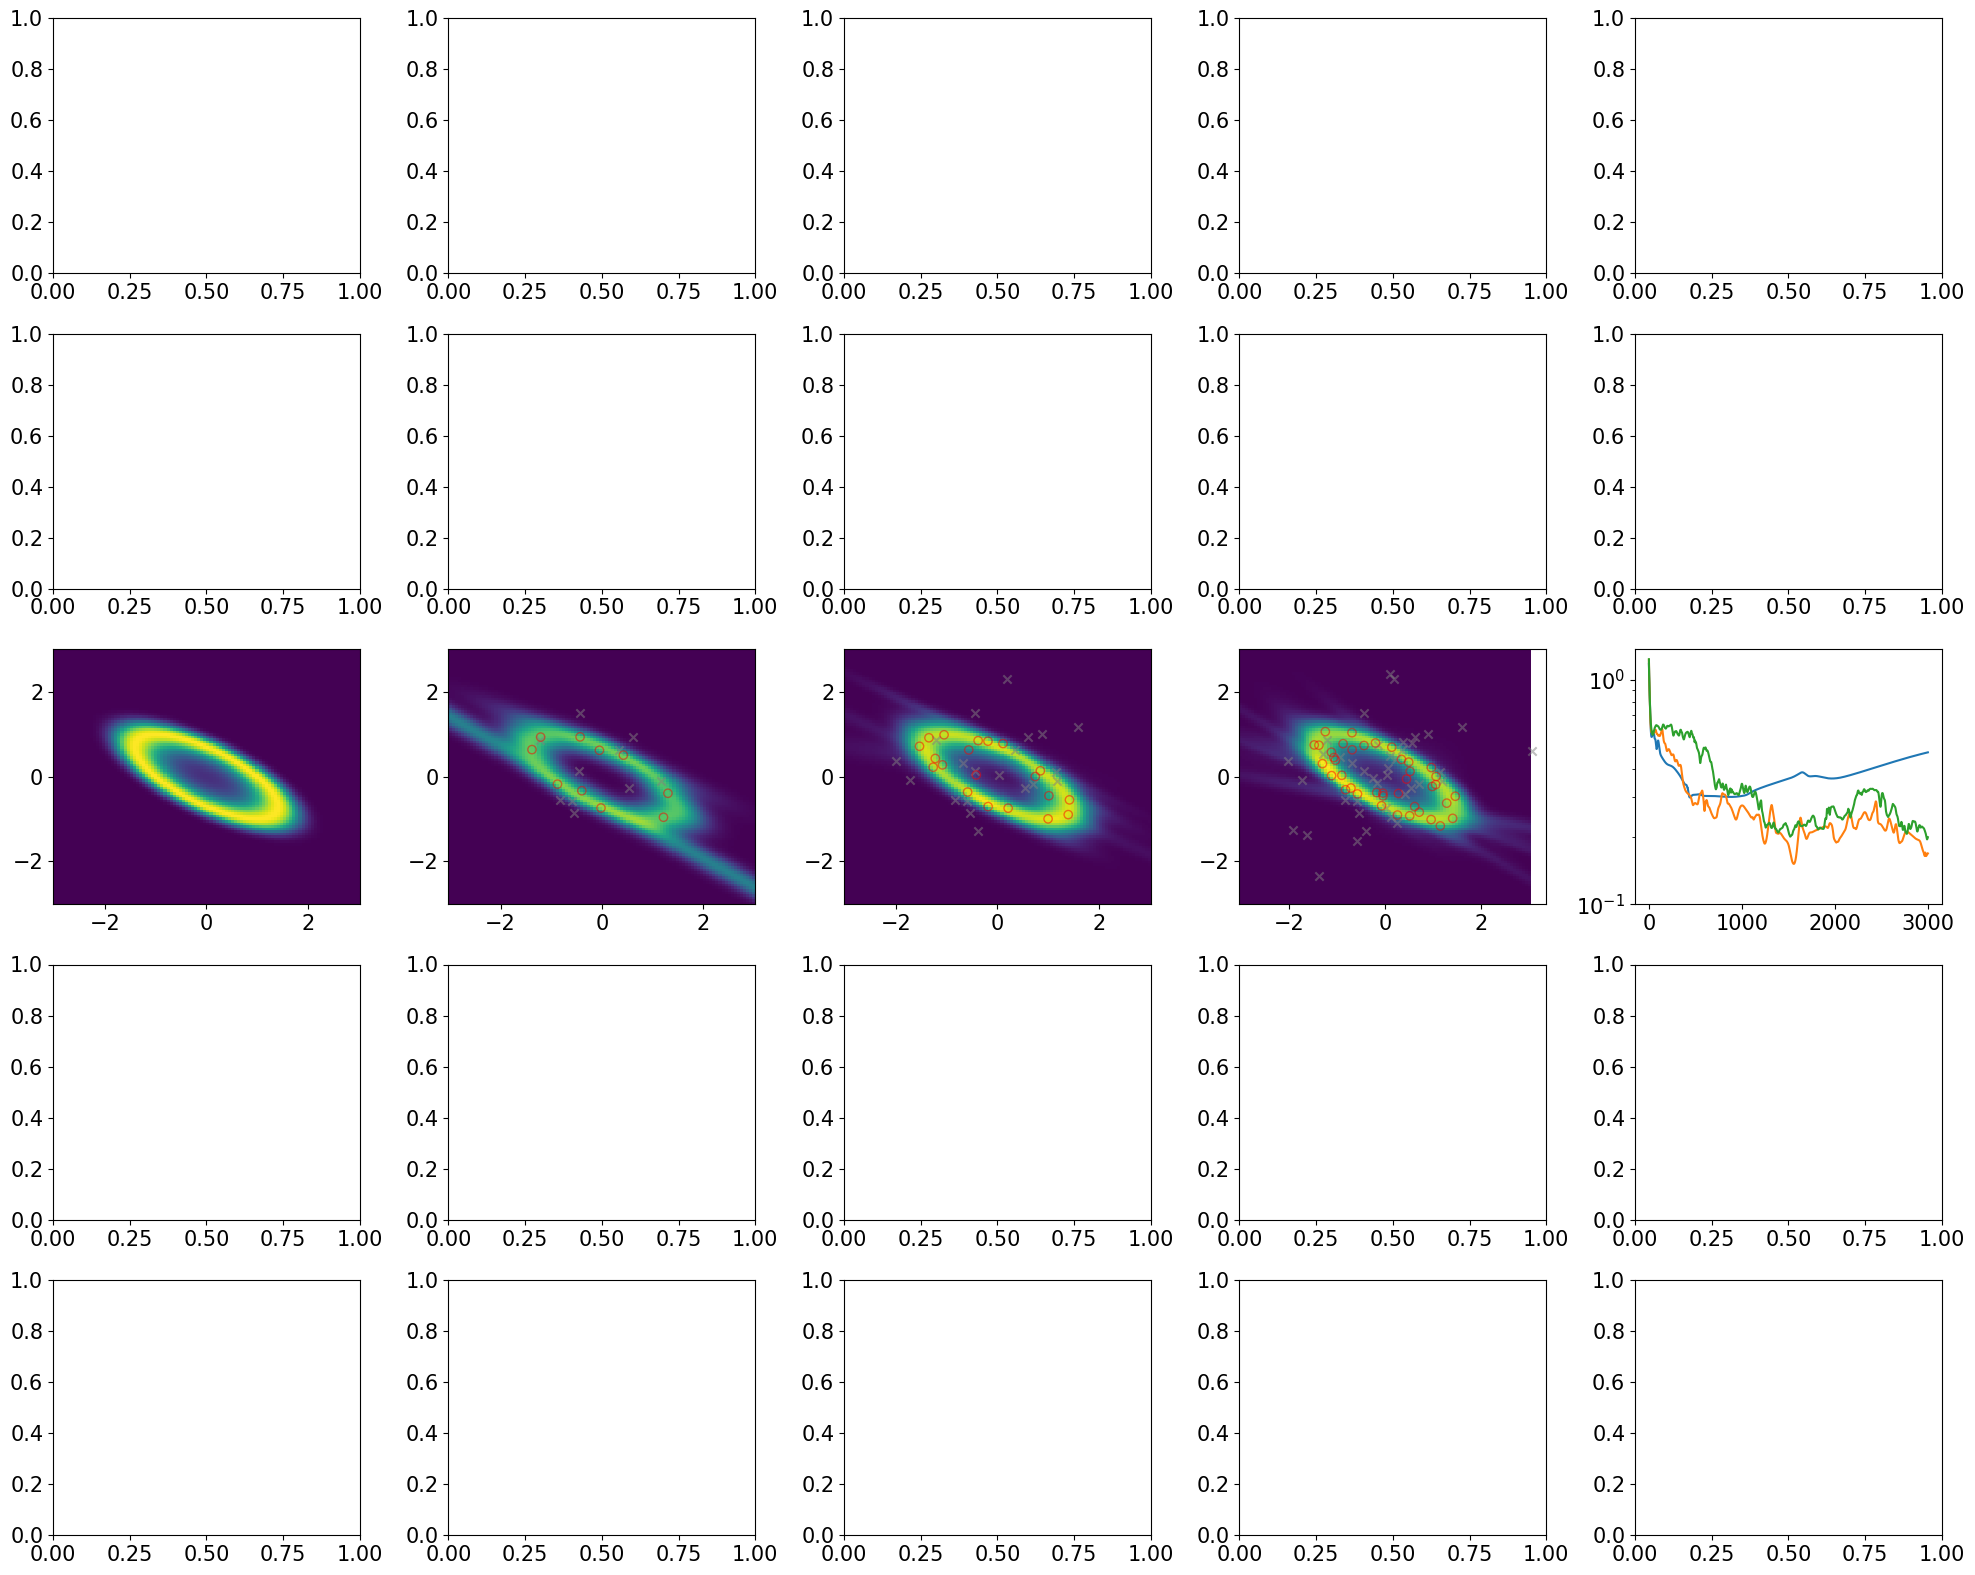

In [ ]:

include("./MultiModal.jl")

N_modes_array = [10; 20; 40]    
fig, ax = PyPlot.subplots(nrows=5, ncols=length(N_modes_array)+2, sharex=false, sharey=false, figsize=(20,16))



Random.seed!(111);
N_modes = N_modes_array[end]
x0_w  = ones(N_modes)/N_modes
μ0, Σ0 = [0.0; 0.0], [1.0 0.0; 0.0 1.0]
N_x = length(μ0)
x0_mean, xx0_cov = zeros(N_modes, N_x), zeros(N_modes, N_x, N_x)
for im = 1:N_modes
    x0_mean[im, :]    .= rand(MvNormal(zeros(N_x), Σ0)) + μ0
    xx0_cov[im, :, :] .= Σ0
end
Hessian_correct_GM = false

N_iter = 3000
Nx, Ny = 100,100

#=

ση = 1.0
Gtype = "Gaussian"
dt = 1.4e-1    #单位：e-1。不可行：1.5，可行：1
A = [1.0 1.0; 1.0 2.0]
y = [0.0; 1.0; zeros(N_x-2)]
func_args = (y, ση, A , Gtype)
func_F(x) = F(x, func_args)
func_dPhi(x) = dPhi(x, func_args)
objs = [Gaussian_mixture_WGFVI(func_dPhi, nothing, x0_w[1:N_modes], x0_mean[1:N_modes,:], xx0_cov[1:N_modes,:,:]; N_iter = N_iter, dt = dt, Hessian_correct_GM=Hessian_correct_GM)[1] 
        for N_modes in N_modes_array]
visualization_2d(ax[1,:]; Nx = Nx, Ny = Ny, x_lim=[-7.0, 5.0], y_lim=[-4.0, 5.0], func_F=func_F, objs=objs, label="GMWVI")



ση = 1.0
dt = 5e-3  #单位1e-3.    2，5可行，5.5，6，7，10，20爆了
Gtype = "Four_modes"
y = [4.2297; 4.2297; 0.5; 0.0; zeros(N_x-2)]
func_args = (y, ση, 0, Gtype)
func_F(x) = F(x, func_args)
func_dPhi(x) = dPhi(x, func_args)
objs = [Gaussian_mixture_WGFVI(func_dPhi, nothing, x0_w[1:N_modes], x0_mean[1:N_modes,:], xx0_cov[1:N_modes,:,:]; N_iter = N_iter, dt = dt, Hessian_correct_GM=Hessian_correct_GM)[1] 
        for N_modes in N_modes_array]
visualization_2d(ax[2,:]; Nx = Nx, Ny = Ny, x_lim=[-4.0, 4.0], y_lim=[-4, 4], func_F=func_F, objs=objs)

=#


ση = [0.5; ones(N_x-2)]
Gtype = "Circle"
dt = 4e-3 #单位e-3  2,5可行 6，10爆掉
A = [1.0 1.0; 1.0 2.0]
y = [1.0; zeros(N_x-2)]
func_args = (y, ση, A , Gtype)
func_F(x) = F(x, func_args)
func_dPhi(x) = dPhi(x, func_args)
μ0, Σ0 = [0.0; 0.0], [1.0 0.0; 0.0 1.0]
objs = [Gaussian_mixture_WGFVI(func_dPhi, x0_w[1:N_modes], x0_mean[1:N_modes,:], xx0_cov[1:N_modes,:,:]; N_iter = N_iter, dt = dt, Hessian_correct_GM=Hessian_correct_GM)[1] 
        for N_modes in N_modes_array]
visualization_2d(ax[3,:]; Nx = Nx, Ny = Ny, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0], func_F=func_F, objs=objs)


#=
ση = [sqrt(10.0); ones(N_x-2)]
Gtype = "Banana"
dt = 2e-3 #单位e-3，2可行，5可能可行，6，8爆了
λ = 10.0
y = [0.0; 1.0; zeros(N_x-2)]
func_args = (y, ση, λ , Gtype)
func_F(x) = F(x, func_args)
func_dPhi(x) = dPhi(x, func_args)
μ0, Σ0 = [0.0; 0.0], [1.0 0.0; 0.0 1.0]
objs = [Gaussian_mixture_WGFVI(func_dPhi, x0_w[1:N_modes], x0_mean[1:N_modes,:], xx0_cov[1:N_modes,:,:]; N_iter = N_iter, dt = dt, Hessian_correct_GM=Hessian_correct_GM)[1] 
        for N_modes in N_modes_array]
visualization_2d(ax[4,:]; Nx = Nx, Ny = Ny, x_lim=[-4.0, 4.0], y_lim=[-2.0, 10.0], func_F=func_F, objs=objs)



ση = [0.3; 1.0; 1.0; ones(N_x-2)]
Gtype = "Double_banana"
dt = 5e-4# 单位1e-4,10 11在1k可以3k不行 12 15 20爆了
λ = 100.0
y = [log(λ+1); 0.0; 0.0; zeros(N_x-2)]
func_args = (y, ση, λ , Gtype)
func_F(x) = F(x, func_args)
func_dPhi(x) = dPhi(x, func_args)
objs = [Gaussian_mixture_WGFVI(func_dPhi, nothing, x0_w[1:N_modes], x0_mean[1:N_modes,:], xx0_cov[1:N_modes,:,:]; N_iter = N_iter, dt = dt, Hessian_correct_GM=Hessian_correct_GM)[1] 
        for N_modes in N_modes_array]
visualization_2d(ax[5,:]; Nx = Nx, Ny = Ny, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0], func_F=func_F, objs=objs)

=#
fig.tight_layout()
# fig.savefig("GMWVI-2D-Multimodal.pdf")





In [5]:
#=
include("./MultiModal.jl")

N_modes_array = [1]   #这里太扯淡了，我决定只用一个[10; 20; 40] 
fig, ax = PyPlot.subplots(nrows=5, ncols=length(N_modes_array)+2, sharex=false, sharey=false, figsize=(20,16))

Random.seed!(111);
N_modes = N_modes_array[end]
x0_w  = ones(N_modes)/N_modes
N_x = 100
μ0, Σ0 = zeros(N_x), Diagonal(ones(N_x))
x0_mean, xx0_cov = zeros(N_modes, N_x), zeros(N_modes, N_x, N_x)
for im = 1:N_modes
    x0_mean[im, :]    .= rand(MvNormal(zeros(N_x), Σ0)) + μ0
    xx0_cov[im, :, :] .= Σ0
end
Hessian_correct_GM = false

N_iter = 3000
Nx, Ny = 100,100


ση = 1.0
Gtype = "Gaussian"
dt = 5e-3
A = [1.0 1.0; 1.0 2.0]
y = [0.0; 1.0; zeros(N_x-2)]
func_args = (y, ση, A , Gtype)
func_F(x) = F(x, func_args)
func_dPhi(x) = dPhi(x, func_args)
objs = [Gaussian_mixture_VI(func_dPhi, nothing, x0_w[1:N_modes], x0_mean[1:N_modes,:], xx0_cov[1:N_modes,:,:]; N_iter = N_iter, dt = dt, Hessian_correct_GM=Hessian_correct_GM)[1] 
        for N_modes in N_modes_array]
# compute marginal distribution
y_2d = y[1:2]
func_args = (y_2d, ση, A , Gtype)
func_F(x) = F(x, func_args)
visualization_2d(ax[1,:]; Nx = Nx, Ny = Ny, x_lim=[-7.0, 5.0], y_lim=[-4.0, 5.0], func_F=func_F, objs=objs, label="DF-GMWVI")

ση = 1.0
dt = 2e-3
Gtype = "Four_modes"
y = [4.2297; 4.2297; 0.5; 0.0; zeros(N_x-2)]
func_args = (y, ση, 0, Gtype)
func_F(x) = F(x, func_args)
func_dPhi(x) = dPhi(x, func_args)
objs = [Gaussian_mixture_VI(func_dPhi, nothing, x0_w[1:N_modes], x0_mean[1:N_modes,:], xx0_cov[1:N_modes,:,:]; N_iter = N_iter, dt = dt, Hessian_correct_GM=Hessian_correct_GM)[1] 
        for N_modes in N_modes_array]
# compute marginal distribution
y_2d = y[1:4]
func_args = (y_2d, ση, A , Gtype)
func_F(x) = F(x, func_args)
visualization_2d(ax[2,:]; Nx = Nx, Ny = Ny, x_lim=[-4.0, 4.0], y_lim=[-4, 4], func_F=func_F, objs=objs)



ση = [0.5; ones(N_x-2)]
Gtype = "Circle"
dt = 5e-3
A = [1.0 1.0; 1.0 2.0]
y = [1.0; zeros(N_x-2)]
func_args = (y, ση, A , Gtype)
func_F(x) = F(x, func_args)
func_dPhi(x) = dPhi(x, func_args)
μ0, Σ0 = [0.0; 0.0], [1.0 0.0; 0.0 1.0]
objs = [Gaussian_mixture_VI(func_dPhi, nothing, x0_w[1:N_modes], x0_mean[1:N_modes,:], xx0_cov[1:N_modes,:,:]; N_iter = N_iter, dt = dt, Hessian_correct_GM=Hessian_correct_GM)[1] 
        for N_modes in N_modes_array]
# compute marginal distribution
y_2d, ση_2d = y[1:1], ση[1:1]
func_args = (y_2d, ση_2d, A , Gtype)
func_F(x) = F(x, func_args)
visualization_2d(ax[3,:]; Nx = Nx, Ny = Ny, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0], func_F=func_F, objs=objs)



ση = [sqrt(10.0); sqrt(10.0); ones(N_x-2)]
Gtype = "Banana"
dt = 2e-3
λ = 10.0
y = [0.0; 1.0; zeros(N_x-2)]
func_args = (y, ση, λ , Gtype)
func_F(x) = F(x, func_args)
func_dPhi(x) = dPhi(x, func_args)
μ0, Σ0 = [0.0; 0.0], [1.0 0.0; 0.0 1.0]
objs = [Gaussian_mixture_VI(func_dPhi, nothing, x0_w[1:N_modes], x0_mean[1:N_modes,:], xx0_cov[1:N_modes,:,:]; N_iter = N_iter, dt = dt, Hessian_correct_GM=Hessian_correct_GM)[1] 
        for N_modes in N_modes_array]
# compute marginal distribution
y_2d, ση_2d = y[1:2], ση[1:2]
func_args = (y_2d, ση_2d, λ , Gtype)
func_F(x) = F(x, func_args)
visualization_2d(ax[4,:]; Nx = Nx, Ny = Ny, x_lim=[-4.0, 4.0], y_lim=[-2.0, 10.0], func_F=func_F, objs=objs)



ση = [0.3; 1.0; 1.0; ones(N_x-2)]
Gtype = "Double_banana"
dt = 1e-5 #
λ = 100.0
y = [log(λ+1); 0.0; 0.0; zeros(N_x-2)]
func_args = (y, ση, λ , Gtype)
func_F(x) = F(x, func_args)
func_dPhi(x) = dPhi(x, func_args)
objs = [Gaussian_mixture_VI(func_dPhi, nothing, x0_w[1:N_modes], x0_mean[1:N_modes,:], xx0_cov[1:N_modes,:,:]; N_iter = N_iter, dt = dt, Hessian_correct_GM=Hessian_correct_GM)[1] 
        for N_modes in N_modes_array]
# compute marginal distribution
y_2d, ση_2d = y[1:3], ση[1:3]
func_args = (y_2d, ση_2d, λ , Gtype)
func_F(x) = F(x, func_args)
visualization_2d(ax[5,:]; Nx = Nx, Ny = Ny, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0], func_F=func_F, objs=objs)


fig.tight_layout()
fig.savefig("GMWVI-100D-Multimodal.pdf")
=#


